In [1]:
# %pip install datasets
# # %pip install evaluate
# import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# !pip install bert-score
# %pip install sacrebleu


In [2]:
%pip install evaluate

In [3]:
from datasets import load_dataset, load_from_disk
import pandas as pd
import datasets

train_data = datasets.load_dataset("wmt16","de-en", split="train[:50000]")
# train_data.select(range(70))
test_data= datasets.load_dataset("wmt16","de-en", split="test")
# test_data.select(range(10))
val_data= datasets.load_dataset("wmt16","de-en", split="validation")
# val_data.select(range(10))

from datasets import DatasetDict


my_dataset_dict = DatasetDict({
    'train': train_data,
    'test': test_data,
    'validation': val_data
})

# Now, my_dataset_dict is a DatasetDict object that contains your datasets.
print(my_dataset_dict)

# from transformers import T5Tokenizer, T5ForConditionalGeneration

# tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
# model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")

from transformers import AutoTokenizer

checkpoint = "google-t5/t5-small"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

source_lang = "de"
target_lang = "en"
prefix = "translate German to English: "


def preprocess_function(examples):
    inputs = [prefix + example[source_lang] for example in examples["translation"]]
    targets = [example[target_lang] for example in examples["translation"]]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True)
    return model_inputs

tokenized_data = my_dataset_dict.map(preprocess_function, batched=True)

from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

import evaluate

metric = evaluate.load("sacrebleu")

import numpy as np


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

from transformers import TrainerCallback

class LossLoggingCallback(TrainerCallback):
    """A custom callback to log training and validation loss."""

    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Log validation loss
        eval_loss = metrics.get('eval_loss')
        if eval_loss is not None:
            self.eval_losses.append(eval_loss)

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Log training loss
        train_loss = logs.get('loss')
        if train_loss is not None:
            self.train_losses.append(train_loss)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2999
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2169
    })
})


Map:   0%|          | 0/2169 [00:00<?, ? examples/s]

In [4]:
%pip install accelerate -U
%pip install transformers[torch]
%pip install accelerate


In [5]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="setup c output",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=6,
    predict_with_generate=True,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=781,
)

loss_logging_callback = LossLoggingCallback()

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[loss_logging_callback],
)

train_output = trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu,Gen Len
1,2.635400,2.176775,7.529700,16.928500
2,2.411000,2.134166,8.228100,16.929900
3,2.339800,2.110495,8.529900,16.941000
4,2.301300,2.097281,8.676600,16.924900
5,2.278200,2.091511,8.715500,16.926700
6,2.266100,2.089124,8.741000,16.930400


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control

[2.6354, 2.411, 2.3398, 2.3013, 2.2782, 2.2661]
[2.1767749786376953, 2.1341655254364014, 2.110494613647461, 2.097280502319336, 2.0915110111236572, 2.0891239643096924]


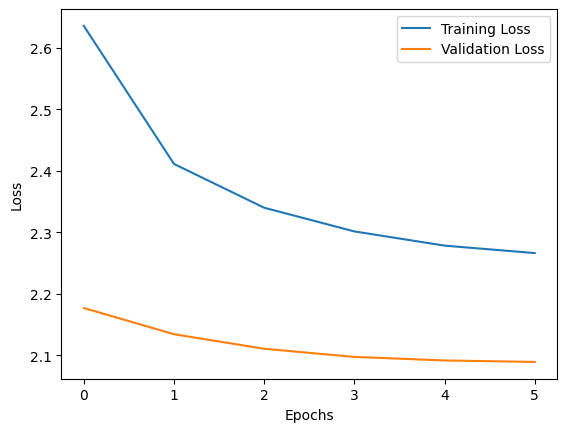

In [6]:
# Initialize lists to hold the losses
train_losses = []
val_losses = []

# Iterate through the log history
for log in trainer.state.log_history:
    # Check for training loss and append when epoch is integer
    if 'loss' in log and log['epoch']:
        train_losses.append(log['loss'])
    # Check for validation loss and append
    if 'eval_loss' in log:
        val_losses.append(log['eval_loss'])

print(train_losses)
print(val_losses)

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [7]:
# Save model

saved_model_name = "Model_Setup_C"
model.save_pretrained(saved_model_name)
tokenizer.save_pretrained(saved_model_name)

# Load model
loaded_model = AutoModelForSeq2SeqLM.from_pretrained(saved_model_name)
loaded_tokenizer = AutoTokenizer.from_pretrained(saved_model_name)

In [8]:
sample_german_text = "Eine Gruppe von Menschen steht vor einem Iglu ."
inputs = loaded_tokenizer([prefix + sample_german_text], return_tensors="pt")

result = loaded_model.generate(**inputs)
translated_text = loaded_tokenizer.batch_decode(result, skip_special_tokens=True)[0]
translated_text

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'A group of people is a group of people.'

In [9]:
import pandas as pd
from tqdm import tqdm

val_data = pd.read_csv('val.csv')
test_data = pd.read_csv('test.csv')

# translate the german to english
translated_text_val = []
translated_text_test = []

for text in tqdm(val_data['de']):
    # generate english translation
    inputs = loaded_tokenizer([prefix + text], return_tensors="pt")
    translated = loaded_model.generate(**inputs)
    # decode the generated token ids
    translated_text_val.append(loaded_tokenizer.decode(translated[0], skip_special_tokens=True))


    # translated = loaded_model.generate(loaded_tokenizer(text, return_tensors="pt").input_ids)
    # translated_text_val.append(loaded_tokenizer.decode(translated[0], skip_special_tokens=True))

for text in tqdm(test_data['de']):
    # generate english translation
    inputs = loaded_tokenizer([prefix + text], return_tensors="pt")
    translated = loaded_model.generate(**inputs)
    # decode the generated token ids
    translated_text_test.append(loaded_tokenizer.decode(translated[0], skip_special_tokens=True))

val_translated_C = val_data.copy()
val_translated_C['pred_en'] = translated_text_val

test_translated_C = test_data.copy()
test_translated_C['pred_en'] = translated_text_test

val_translated_C.to_csv('val_translated_C.csv', index=False)
test_translated_C.to_csv('test_translated_C.csv', index=False)

  0%|          | 0/2169 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 2999/2999 [23:26<00:00,  2.13it/s]


In [10]:
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk import word_tokenize
import numpy as np

# Function to calculate BLEU scores
def calculate_bleu_scores(data):
    bleu_1_scores = []
    bleu_2_scores = []
    bleu_3_scores = []
    bleu_4_scores = []

    for index, row in data.iterrows():
        reference = [word_tokenize(row['en'].lower(), language='english')]
        candidate = word_tokenize(row['pred_en'].lower(), language='english')

        bleu_1 = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)
        bleu_2 = sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=SmoothingFunction().method1)
        bleu_3 = sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0), smoothing_function=SmoothingFunction().method1)
        bleu_4 = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=SmoothingFunction().method1)

        bleu_1_scores.append(bleu_1)
        bleu_2_scores.append(bleu_2)
        bleu_3_scores.append(bleu_3)
        bleu_4_scores.append(bleu_4)

    return np.mean(bleu_1_scores), np.mean(bleu_2_scores), np.mean(bleu_3_scores), np.mean(bleu_4_scores)

# Calculate BLEU scores for the validation data
bleu_1, bleu_2, bleu_3, bleu_4 = calculate_bleu_scores(val_translated_C)
print("BLEU Scores for Validation Data")
print(f'BLEU-1 Score: {bleu_1}')
print(f'BLEU-2 Score: {bleu_2}')
print(f'BLEU-3 Score: {bleu_3}')
print(f'BLEU-4 Score: {bleu_4}')
print(f'Net BLEU Score: {(bleu_1 + bleu_2 + bleu_3 + bleu_4) / 4}')

print()

# Calculate BLEU scores for the test data
bleu_1, bleu_2, bleu_3, bleu_4 = calculate_bleu_scores(test_translated_C)
print("BLEU Scores for Test Data")
print(f'BLEU-1 Score: {bleu_1}')
print(f'BLEU-2 Score: {bleu_2}')
print(f'BLEU-3 Score: {bleu_3}')
print(f'BLEU-4 Score: {bleu_4}')
print(f'Net BLEU Score: {(bleu_1 + bleu_2 + bleu_3 + bleu_4) / 4}')

BLEU Scores for Validation Data
BLEU-1 Score: 0.325526593675111
BLEU-2 Score: 0.20337975053173896
BLEU-3 Score: 0.13648549156545534
BLEU-4 Score: 0.095513300300912
Net BLEU Score: 0.19022628401830433

BLEU Scores for Test Data
BLEU-1 Score: 0.3419198855170624
BLEU-2 Score: 0.222498149760997
BLEU-3 Score: 0.1525081634674318
BLEU-4 Score: 0.10777390221426447
Net BLEU Score: 0.2061750252399389


In [11]:
import evaluate

# Assuming you have your 'en' and 'pred_en' lists from the DataFrame
references_val =  val_translated_C['en'].tolist()  # Your target translations
predictions_val = val_translated_C['pred_en'].tolist()  # Your predicted translations

meteor_score_val = evaluate.load("meteor")
results_val = meteor_score_val.compute(predictions=predictions_val, references=references_val)
print(f"METEOR Score on Validation Data: {results_val['meteor']}")

references_test =  test_translated_C['en'].tolist()  # Your target translations
predictions_test = test_translated_C['pred_en'].tolist()  # Your predicted translations

meteor_score_test = evaluate.load("meteor")
results_test = meteor_score_test.compute(predictions=predictions_test, references=references_test)
print(f"METEOR Score on Test Data: {results_test['meteor']}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


METEOR Score on Validation Data: 0.3258884327181929


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


METEOR Score on Test Data: 0.34977658300754577


In [12]:
bertscore = evaluate.load("bertscore")

results_val = bertscore.compute(predictions=predictions_val, references=references_val, lang="en")
print("BERTScore on Validation Data")
print(f"BERTScore Precision: {np.mean(results_val['precision'])}")
print(f"BERTScore Recall: {np.mean(results_val['recall'])}")
print(f"BERTScore F1: {np.mean(results_val['f1'])}")

print()

results_test = bertscore.compute(predictions=predictions_test, references=references_test, lang="en")
print("BERTScore on Test Data")
print(f"BERTScore Precision: {np.mean(results_test['precision'])}")
print(f"BERTScore Recall: {np.mean(results_test['recall'])}")
print(f"BERTScore F1: {np.mean(results_test['f1'])}")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERTScore on Validation Data
BERTScore Precision: 0.8948922722281372
BERTScore Recall: 0.8848619980161341
BERTScore F1: 0.8896571953431864

BERTScore on Test Data
BERTScore Precision: 0.8961075284195645
BERTScore Recall: 0.8858878665782881
BERTScore F1: 0.8907722380408528
